Loaded Raster: Data/BELGIUM_Average_PM10_2022.tif, Shape = (21, 39)

--- Running Elbow Method (Curvature-Based) ---
SSD for K=1: nan
SSD for K=2: nan
SSD for K=3: nan
SSD for K=4: nan
SSD for K=5: nan
SSD for K=6: nan
SSD for K=7: nan
SSD for K=8: nan
SSD for K=9: nan
SSD for K=10: nan

 Optimal K (Curvature/Kneedle Method): 1



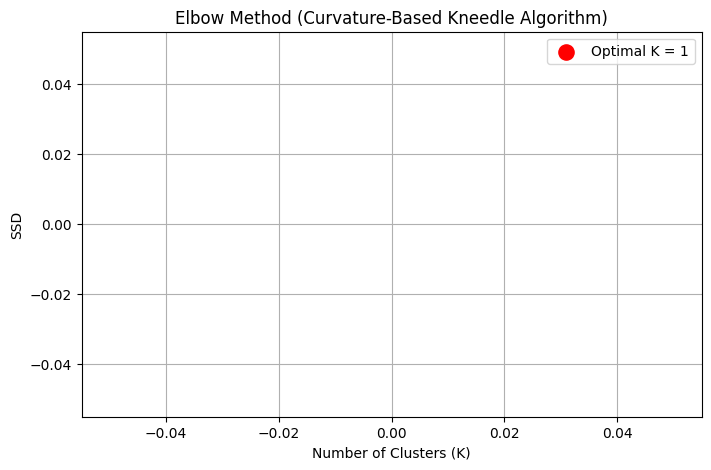


Final Centroids:

 FINAL FLOAT CENTROIDS FROM K-MEANS:
[nan]

 Number of centroids: 1

--- Saving Classified Raster to: OUTPUT FILE PATH AND NAME ---
Raster successfully saved!



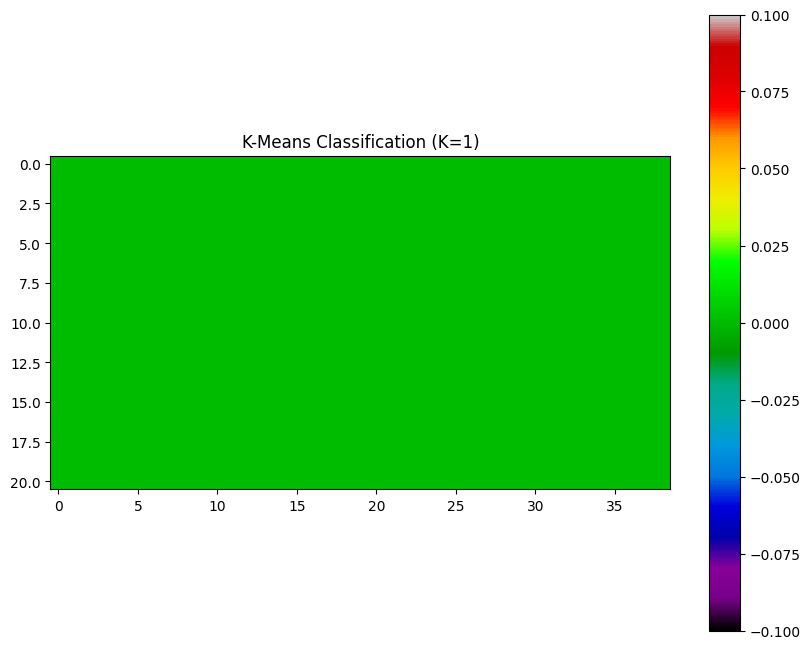

In [18]:
# By : Ayman Mutasim

import numpy as np
import matplotlib.pyplot as plt
import rasterio

# --- CONFIGURATION ---
RASTER_FILE_PATH = "Data/BELGIUM_Average_PM10_2022.tif"
MAX_CLUSTERS_TO_TEST = 10
OUTPUT_RASTER_PATH = "OUTPUT FILE PATH AND NAME"


# --------------------------------------------------------
# PRINT CENTROIDS
# --------------------------------------------------------
def show_cluster_centroids(centroids):
    print("\n FINAL FLOAT CENTROIDS FROM K-MEANS:")
    print(np.array(centroids))
    print(f"\n Number of centroids: {len(centroids)}")


# --------------------------------------------------------
# K-MEANS (FLOAT CENTROIDS)
# --------------------------------------------------------
def kmeans_single_band(data_2d, k, max_iters=100, tolerance=1e-4, seed=42):
    x, y = data_2d.shape
    reshaped = data_2d.reshape(-1, 1)

    np.random.seed(seed)
    centroids = reshaped[np.random.choice(reshaped.shape[0], k, replace=False)].flatten().astype(float)

    for _ in range(max_iters):
        distances = np.abs(reshaped - centroids)
        closest = np.argmin(distances, axis=1)

        new_centroids = np.zeros(k)
        for i in range(k):
            pts = reshaped[closest == i]
            new_centroids[i] = pts.mean() if pts.size > 0 else centroids[i]

        if np.all(np.abs(new_centroids - centroids) < tolerance):
            break

        centroids = new_centroids

    ssd = np.sum(np.min(np.abs(reshaped - centroids), axis=1)**2)
    return closest.reshape(x, y), centroids, ssd


# --------------------------------------------------------
# WRITE RASTER
# --------------------------------------------------------
def save_classified_raster(output_data, output_path, src_profile):
    print(f"\n--- Saving Classified Raster to: {output_path} ---")

    out_profile = src_profile.copy()
    out_profile.update({'dtype': output_data.dtype, 'count': 1, 'nodata': None})

    with rasterio.open(output_path, 'w', **out_profile) as dst:
        dst.write(output_data, 1)

    print("Raster successfully saved!\n")


# --------------------------------------------------------
# CURVATURE-BASED ELBOW DETECTION (KNEEDLE METHOD)
# --------------------------------------------------------
def find_elbow_kneedle(k_vals, ssd_vals):
    # Normalize both axes
    x = (k_vals - k_vals.min()) / (k_vals.max() - k_vals.min())
    y = (ssd_vals - ssd_vals.min()) / (ssd_vals.max() - ssd_vals.min())

    # Line between first and last points
    x1, y1 = x[0], y[0]
    x2, y2 = x[-1], y[-1]

    # Compute perpendicular distance to the line
    distances = np.abs((y2 - y1)*x - (x2 - x1)*y + x2*y1 - y2*x1) / np.sqrt((y2 - y1)**2 + (x2 - x1)**2)

    # Elbow = point with maximum distance
    idx = np.argmax(distances)
    return int(k_vals[idx])


# --------------------------------------------------------
# MAIN WORKFLOW
# --------------------------------------------------------
def classify_single_band_raster(file_path, max_k=10, output_path=None):

    # LOAD RASTER
    with rasterio.open(file_path) as src:
        if src.count != 1:
            print(" Must be single-band raster.")
            return

        profile = src.profile
        data = src.read(1).astype(float)
        flat = data.flatten()

    print(f"Loaded Raster: {file_path}, Shape = {data.shape}")

    # --- STEP 1: COLLECT SSD VALUES ---
    ssd_vals = []
    k_vals = np.arange(1, max_k + 1)

    print("\n--- Running Elbow Method (Curvature-Based) ---")
    for k in k_vals:
        if k == 1:
            mean_val = flat.mean()
            ssd = np.sum((flat - mean_val)**2)
        else:
            _, _, ssd = kmeans_single_band(data.copy(), k)

        ssd_vals.append(ssd)
        print(f"SSD for K={k}: {ssd}")

    ssd_vals = np.array(ssd_vals, float)

    # --- STEP 2: ELBOW USING CURVATURE (KNEEDLE) ---
    optimal_k = find_elbow_kneedle(k_vals, ssd_vals)
    print(f"\n Optimal K (Curvature/Kneedle Method): {optimal_k}\n")

    # --- STEP 3: PLOT ---
    plt.figure(figsize=(8, 5))
    plt.plot(k_vals, ssd_vals, 'o--')
    plt.scatter(optimal_k, ssd_vals[optimal_k - 1], color='red', s=120, label=f"Optimal K = {optimal_k}")
    plt.legend()
    plt.title("Elbow Method (Curvature-Based Kneedle Algorithm)")
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("SSD")
    plt.grid()
    plt.show()

    # --- STEP 4: FINAL CLASSIFICATION ---
    labels, centroids, _ = kmeans_single_band(data, optimal_k)

    print("\nFinal Centroids:")
    show_cluster_centroids(centroids)

    out_flat = np.zeros(flat.size, float)
    labs_flat = labels.flatten()

    for i in range(optimal_k):
        out_flat[labs_flat == i] = centroids[i]

    out_raster = out_flat.reshape(data.shape)

    # SAVE OUTPUT
    if output_path:
        save_classified_raster(out_raster, output_path, profile)

    # SHOW LABELS
    plt.figure(figsize=(10, 8))
    plt.imshow(labels, cmap='nipy_spectral')
    plt.title(f"K-Means Classification (K={optimal_k})")
    plt.colorbar()
    plt.show()


# ---------------------------------------------------------
# RUN WORKFLOW
# ---------------------------------------------------------
classify_single_band_raster(RASTER_FILE_PATH, MAX_CLUSTERS_TO_TEST, OUTPUT_RASTER_PATH)
